In [1]:
import re
import cv2
import time
import random
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed

import config as c
import utils.image_processing as ipr
import utils.model as model_factory
from utils.dataset import get_train_data, get_test_data

plt.rcParams["figure.figsize"] = (10, 10)

In [2]:
x, y = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(80, 80), values_linear_transformation=False)
x = np.array(x)[:,:,:,0]
y = np.array(y)[:, 1].reshape((-1, 1)).astype(np.float)

100%|██████████| 6646/6646 [00:00<00:00, 36120.22it/s]


In [14]:
img=x[0]

In [15]:
img

array([[ 93., 105., 104., ...,  86., 101., 108.],
       [102., 103., 103., ..., 103., 104.,  96.],
       [101.,  96., 100., ...,  97., 108., 101.],
       ...,
       [110., 102.,  98., ...,  97.,  88.,  98.],
       [101.,  99., 108., ..., 101.,  99., 100.],
       [ 98.,  96.,  99., ...,  99.,  95.,  98.]], dtype=float32)

In [16]:
def create_circular_mask(h, w, center=None, radius=None):
    if center is None:
        center = (int(w/2), int(h/2))
    if radius is None:
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def get_matrix(img):
    img = sp.ndimage.filters.gaussian_filter(img, [2.0, 2.0])
    m = np.zeros((80, 40))
    for v in range(90, 170):
        for r in range(2, 42):
            m[v-90, r-2] = np.sum(create_circular_mask(80, 80, radius=r) * (img>v))/r/r
    return m

In [17]:
matrixs = Parallel(n_jobs=c.NUM_CORES)(delayed(get_matrix)(img) for img in tqdm(x))
matrixs=np.array(matrixs)

100%|██████████| 6646/6646 [01:32<00:00, 71.51it/s]


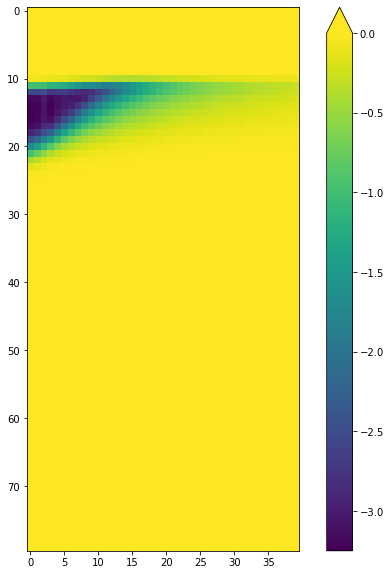

In [18]:
averaged_matrices = []

for energy in [1, 6, 20]:
    m = np.zeros((40, 75))
    imgs = np.array(matrixs)[(y==energy).reshape(-1)]
    
    #for img in tqdm(imgs[:20]):
    #    m += get_matrix(img) / len(imgs)
    m = np.sum(imgs, axis=0) / len(imgs)
    averaged_matrices.append(m)

pos = plt.imshow(averaged_matrices[0]-averaged_matrices[1])
plt.colorbar(pos, extend='max')
plt.show()

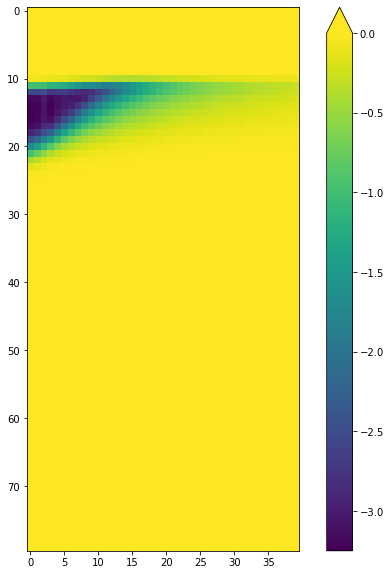

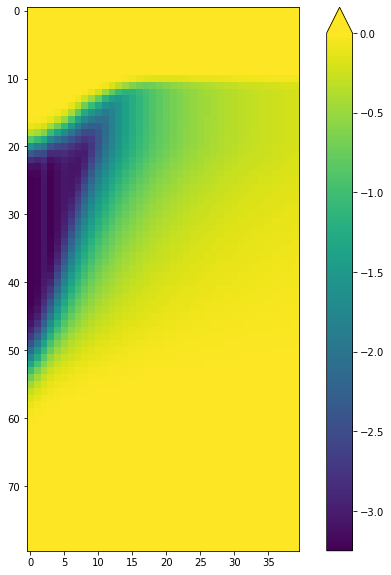

In [19]:
pos = plt.imshow(averaged_matrices[0]-averaged_matrices[1])
plt.colorbar(pos, extend='max')
plt.show()
pos = plt.imshow(averaged_matrices[1]-averaged_matrices[2])
plt.colorbar(pos, extend='max')
plt.show()

In [20]:
np.sum(np.sum(matrixs-averaged_matrices[0], axis=1), axis=1)/80/80

array([5.48192196e-02, 2.40893342e-01, 2.00439907e-01, ...,
       2.67905312e-01, 5.55725848e-02, 1.57566053e-04])

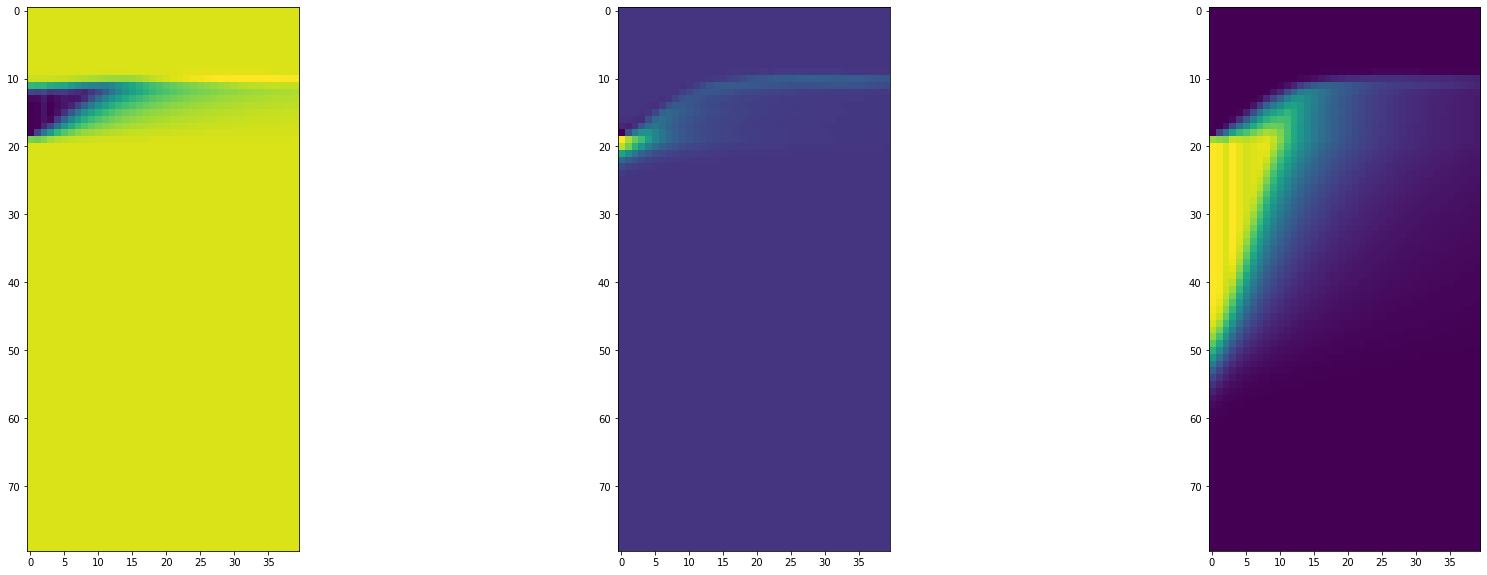

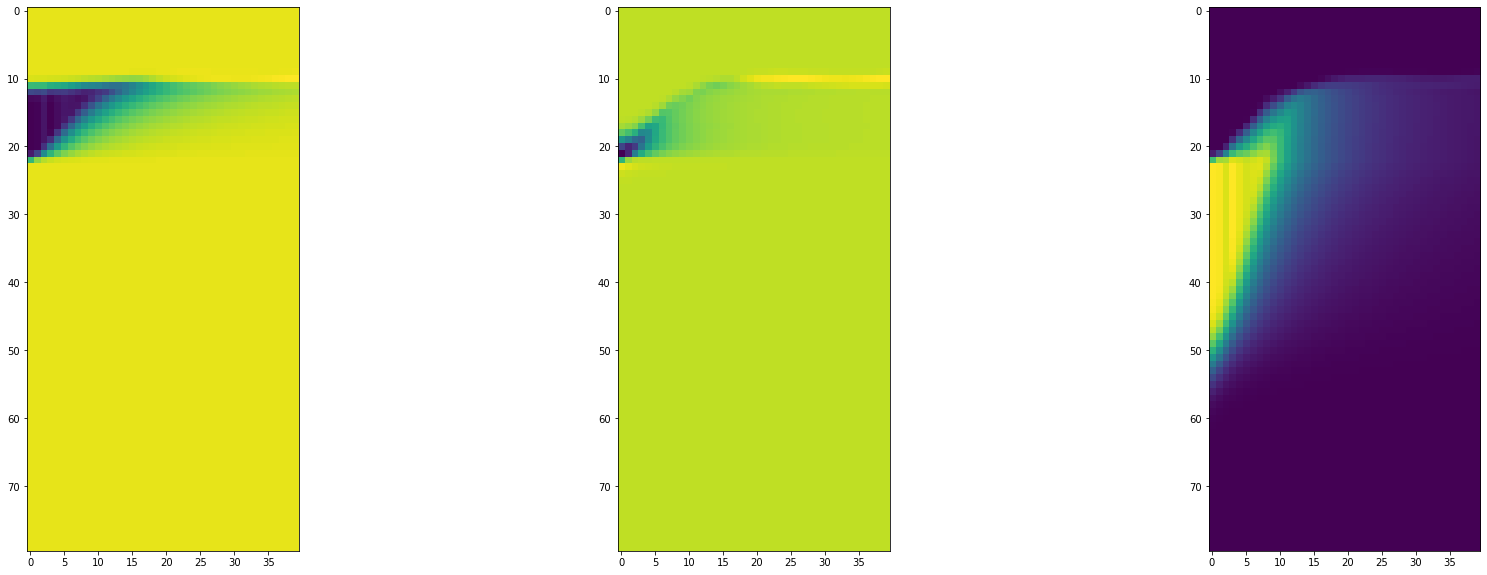

In [21]:
r = np.sum(np.sum(matrixs-averaged_matrices[0], axis=1), axis=1)/80/80
for i in range(2):
    img = random.choice(x[(y.reshape(-1)==6)&(r<10)])
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    for j in range(3):
        m = averaged_matrices[j] - get_matrix(img)
        pos = axs[j].imshow(m)
    #fig.colorbar(pos, extend='max')
    plt.show()

In [22]:
r = np.sum(np.sum((matrixs-averaged_matrices[0])**3, axis=1), axis=1)/80/80
for index in [1, 3, 6, 10, 20, 30]:
    d=r[y.reshape(-1)==index]
    print('{:d}\t{:01.3f} {:01.3f} {:01.3f}'.format(index, np.min(d), np.mean(d), np.max(d)))
print()

r = np.sum(np.sum((matrixs-averaged_matrices[1])**3, axis=1), axis=1)/80/80
for index in [1, 3, 6, 10, 20, 30]:
    d=r[y.reshape(-1)==index]
    print('{:d}\t{:01.3f} {:01.3f} {:01.3f}'.format(index, np.min(d), np.mean(d), np.max(d)))
print()

r = np.sum(np.sum((matrixs-averaged_matrices[2])**3, axis=1), axis=1)/80/80
for index in [1, 3, 6, 10, 20, 30]:
    d=r[y.reshape(-1)==index]
    print('{:d}\t{:01.4f} {:01.4f} {:01.4f}'.format(index, np.min(d), np.mean(d), np.max(d)))

1	-0.048 0.000 0.048
3	0.082 0.084 0.086
6	0.104 0.276 0.522
10	0.595 0.612 0.629
20	1.093 1.496 1.993
30	1.952 2.158 2.364

1	-0.382 -0.264 -0.142
3	-0.116 -0.102 -0.088
6	-0.082 -0.000 0.104
10	0.158 0.174 0.190
20	0.605 0.976 1.444
30	1.419 1.617 1.815

1	-1.6067 -1.4762 -1.3257
3	-1.2765 -1.2598 -1.2430
6	-1.2327 -0.9709 -0.6683
10	-0.5724 -0.5515 -0.5306
20	-0.1338 -0.0002 0.1449
30	0.1214 0.2545 0.3875


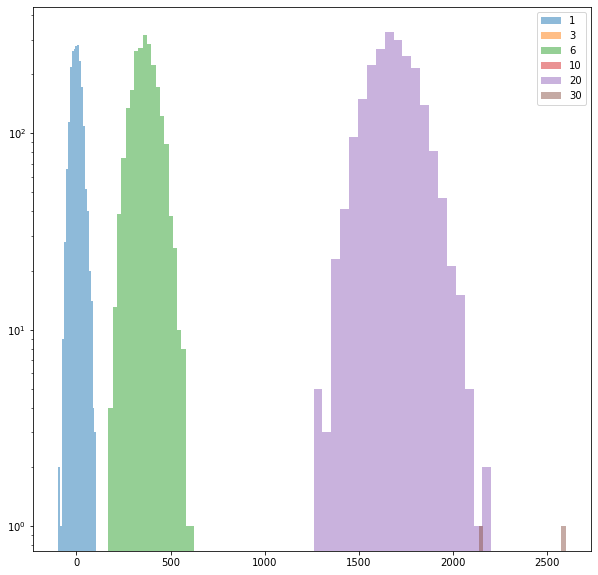

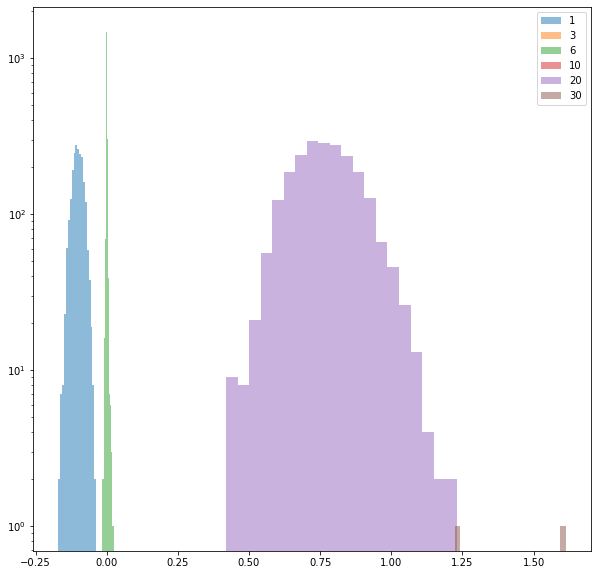

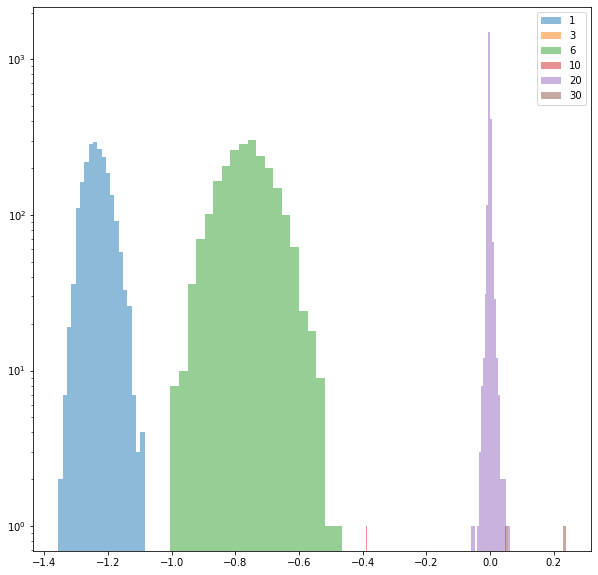

In [12]:
r = np.sum(np.sum((matrixs-averaged_matrices[0]), axis=1), axis=1)
for index in [1, 3, 6, 10, 20, 30]:
    plt.hist(r[y.reshape(-1)==index], log=True, bins=20, alpha=0.5, label=str(index))
plt.legend()
plt.plot()
plt.show()

r = np.sum(np.sum((matrixs-averaged_matrices[1])**3, axis=1), axis=1)/80/80
for index in [1, 3, 6, 10, 20, 30]:
    plt.hist(r[y.reshape(-1)==index], log=True, bins=20, alpha=0.5, label=str(index))
plt.legend()
plt.plot()
plt.show()

r = np.sum(np.sum((matrixs-averaged_matrices[2])**3, axis=1), axis=1)/80/80
for index in [1, 3, 6, 10, 20, 30]:
    plt.hist(r[y.reshape(-1)==index], log=True, bins=20, alpha=0.5, label=str(index))
plt.legend()
plt.plot()
plt.show()

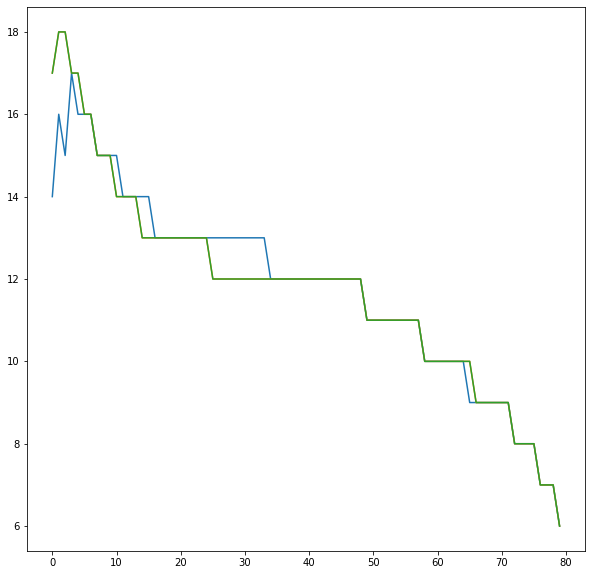

In [696]:
m = random.choice(x[(y.reshape(-1)==20)])
m = sp.ndimage.filters.gaussian_filter(m, [1.0, 1.0])
m = get_matrix(random.choice(x[(y.reshape(-1)==3)]) )>0.9
plt.plot(np.sum(m, axis=0))

m = random.choice(x[(y.reshape(-1)==10)])
m = sp.ndimage.filters.gaussian_filter(m, [1.0, 1.0])
m = get_matrix(random.choice(x[(y.reshape(-1)==3)]) )>0.9
plt.plot(np.sum(m, axis=0))

m = random.choice(x[(y.reshape(-1)==6)])
m = sp.ndimage.filters.gaussian_filter(m, [1.0, 1.0])
m = get_matrix(random.choice(x[(y.reshape(-1)==3)]) )>0.9
plt.plot(np.sum(m, axis=0))

In [325]:
r[y.reshape(-1)==3]

array([-1.07836358, -1.03594682])

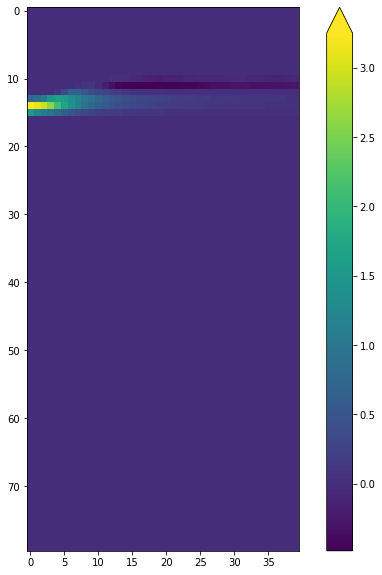

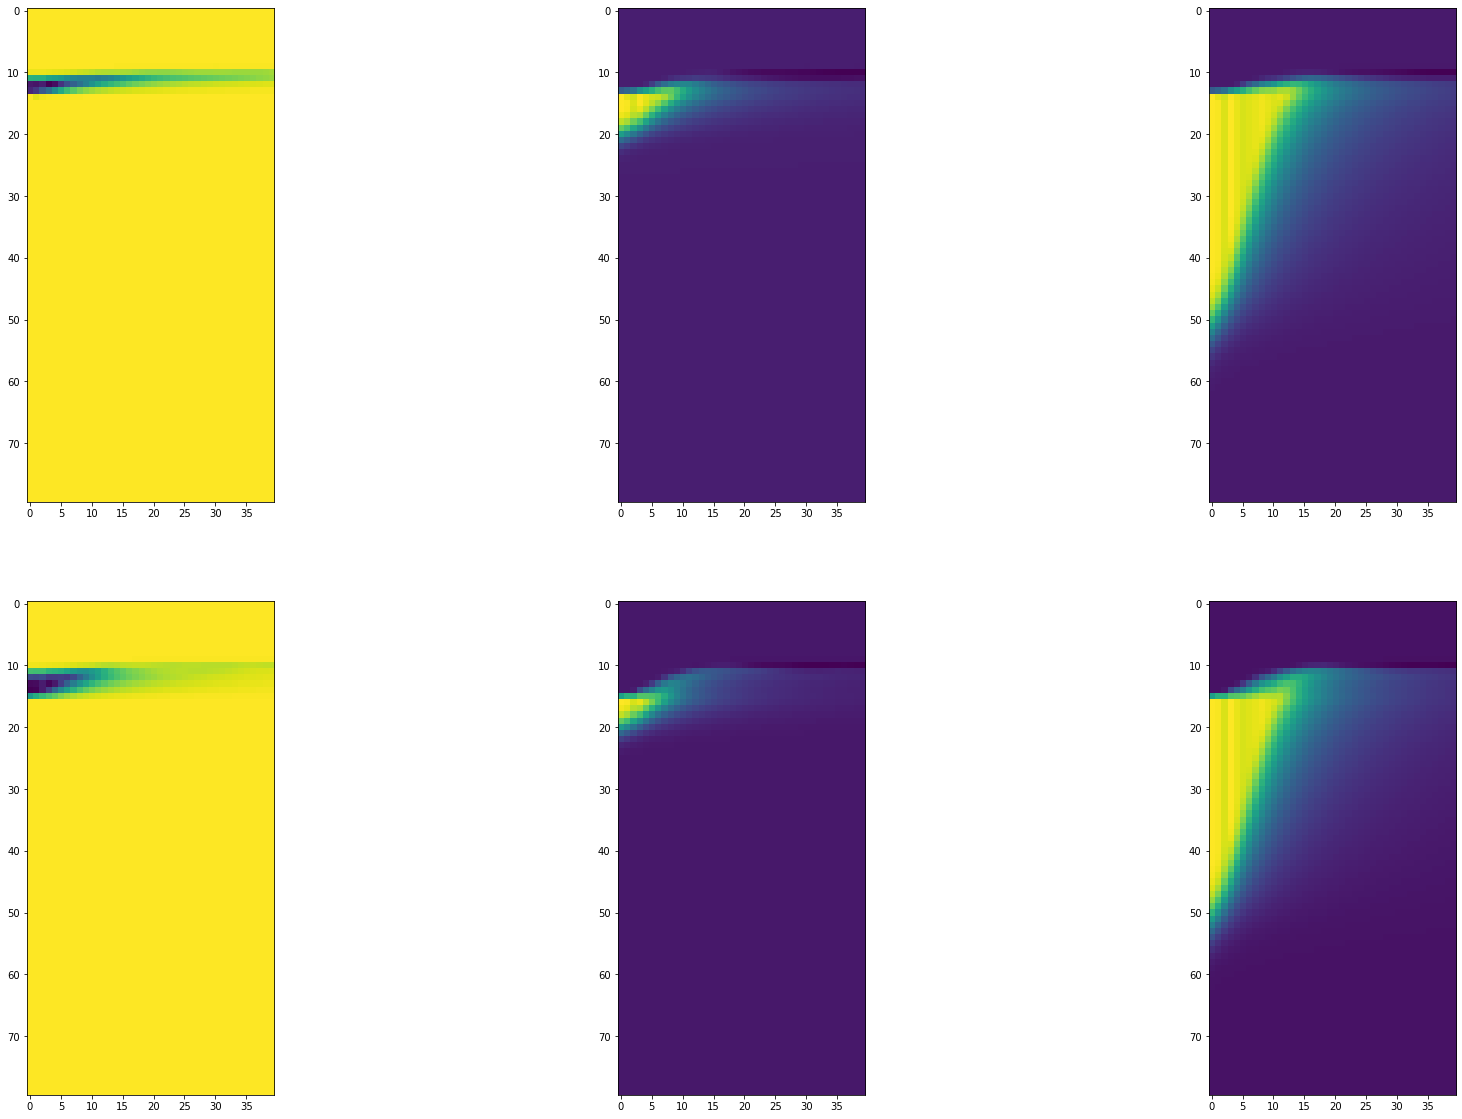

In [23]:
r = np.sum(np.sum((matrixs-averaged_matrices[0]), axis=1), axis=1)
for i in range(1):
    img_0 = random.choice(x[(y.reshape(-1)==1)&(r>100)])
    img_1 = random.choice(x[(y.reshape(-1)==3)&(r<200)])
    img_0 = sp.ndimage.filters.gaussian_filter(img_0, [1.0, 1.0])
    img_1 = sp.ndimage.filters.gaussian_filter(img_1, [1.0, 1.0])
    
    
    m = get_matrix(img_1) - get_matrix(img_0)
    pos = plt.imshow(m)
    plt.colorbar(pos, extend='max')
    plt.show()
    
    fig, axs = plt.subplots(2, 3, figsize=(30, 20))
    for j in range(3):
        m = averaged_matrices[j] - get_matrix(img_0)
        pos = axs[0, j].imshow(m)
    
    for j in range(3):
        m = averaged_matrices[j] - get_matrix(img_1)
        pos = axs[1, j].imshow(m)

    #
    plt.show()
    


In [327]:
img = random.choice(x[(y.reshape(-1)==index)])
m = get_matrix(img)

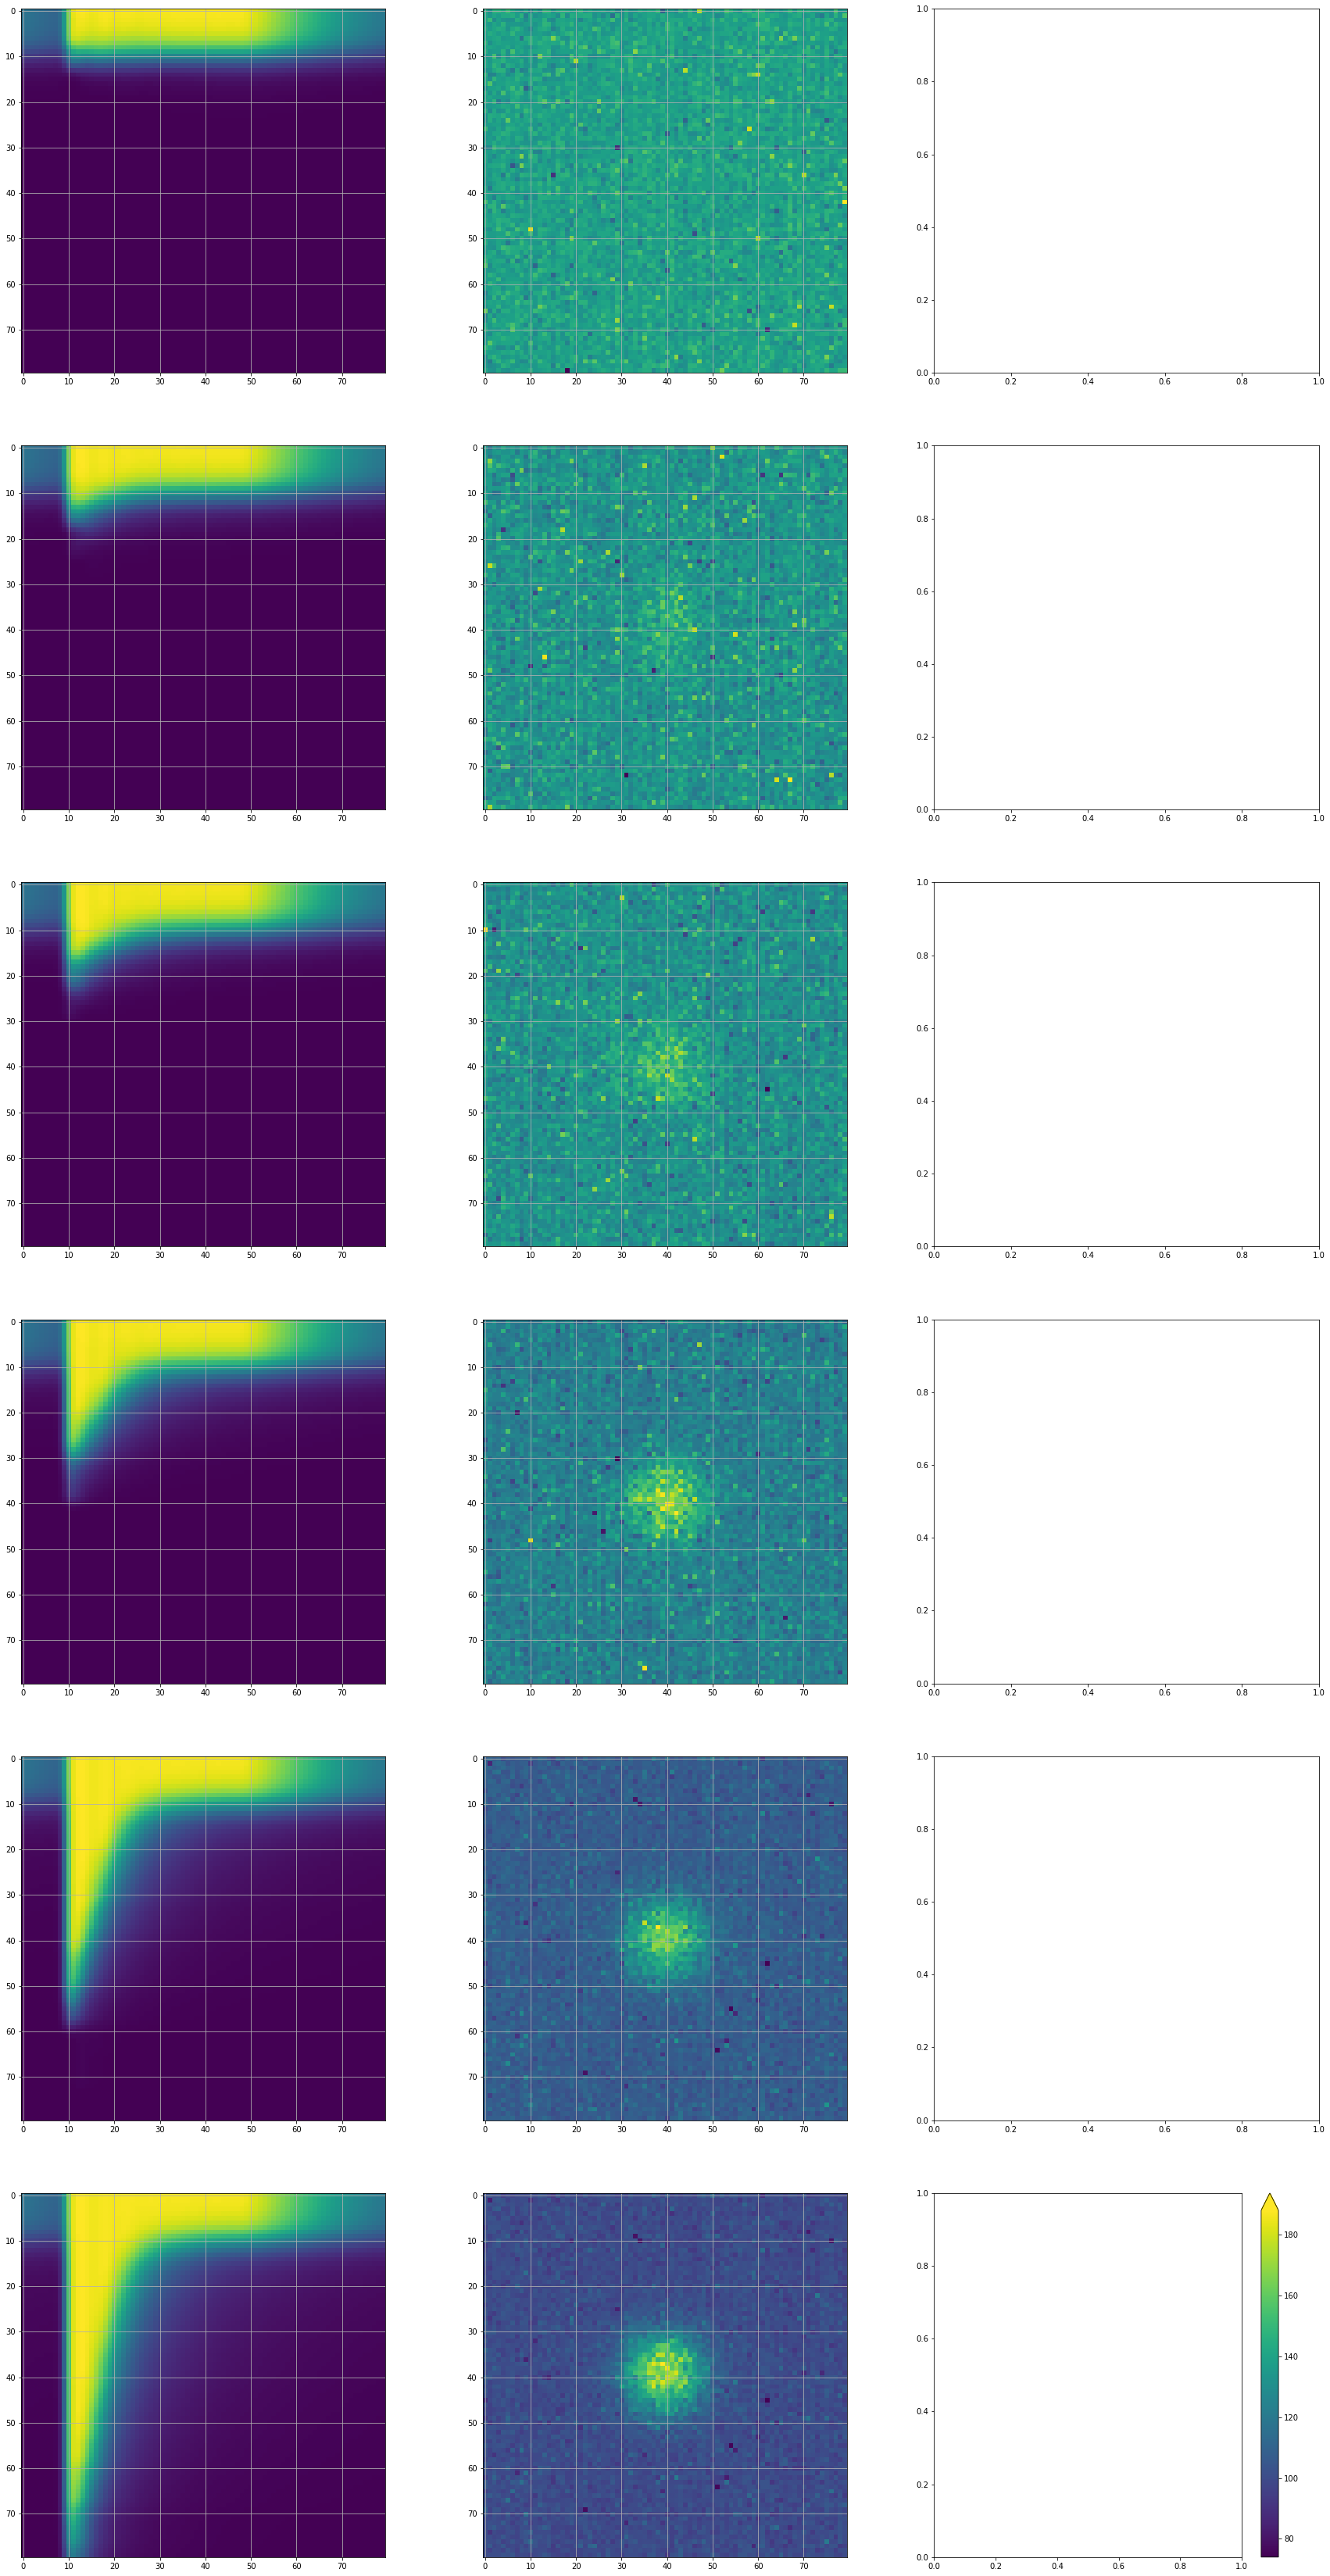

In [673]:
r = np.sum(np.sum((matrixs-averaged_matrices[0]), axis=1), axis=1)
fig, axs = plt.subplots(6, 3, figsize=(30, 60))
for i, index in enumerate([1, 3, 6, 10, 20, 30]):    
    
    for j in range(1):
        img = random.choice(x[(y.reshape(-1)==index)])
        #img = sp.ndimage.filters.gaussian_filter(img, [2.0, 2.0])
        
        m = get_matrix(img)
        m = sp.ndimage.filters.gaussian_filter(m, [1.0, 1.0])
        #m = (np.gradient(m)[0]**2+np.gradient(m)[1]**2)**0.5
        
        #m = cv2.resize(m, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
        #m = ((m>np.mean(m)*0.9)&(m<np.mean(m)*1.1))|((m>np.mean(m)*0.5)&(m<np.mean(m)*0.6))|((m>np.mean(m)*0.1)&(m<np.mean(m)*0.15))
        pos = axs[i, j].imshow(m)
        pos = axs[i, 1].imshow(img)
        axs[i, 1].grid()
        axs[i, j].grid()
fig.colorbar(pos, extend='max')
plt.show()

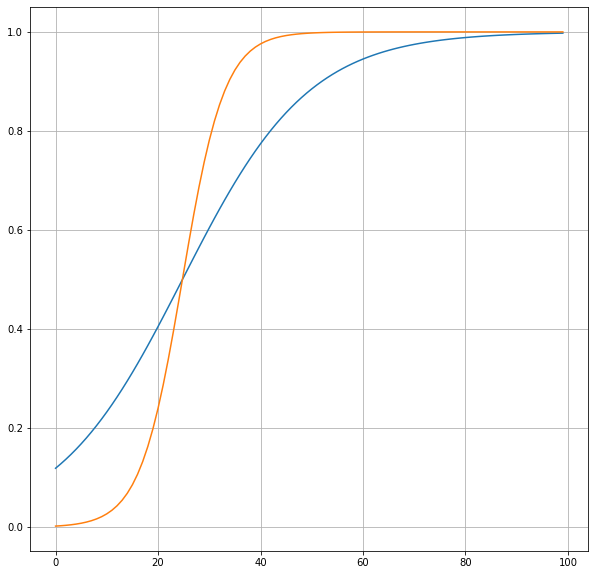

In [654]:
_x=np.linspace(-1, 3, 100)

_y=(np.tanh(_x)/2+0.5)
plt.plot(_y)

_y=(np.tanh(_x*3)/2+0.5)
plt.plot(_y)

plt.grid()

In [662]:
matrixs[0][0,:]

array([3.25      , 3.22222222, 3.0625    , 3.24      , 3.13888889,
       3.04081633, 3.078125  , 3.12345679, 3.16      , 3.10743802,
       3.05555556, 3.12426036, 3.12244898, 3.14666667, 3.109375  ,
       3.11072664, 3.10185185, 3.11634349, 3.1325    , 3.10430839,
       3.12603306, 3.11531191, 3.09895833, 3.12      , 3.1183432 ,
       3.12071331, 3.10969388, 3.10820452, 3.11555556, 3.10509886,
       3.11425781, 3.11019284, 3.1150519 , 3.12571429, 3.10725309,
       3.11541271, 3.10595568, 3.11900066, 3.116875  , 3.08268888,
       3.03628118, 2.97890752, 2.91890496, 2.84938272, 2.77032136,
       2.69850611, 2.61848958, 2.54768846, 2.4704    , 2.39600154,
       2.31952663, 2.24101104, 2.17078189, 2.09619835, 2.02582908,
       1.95567867, 1.88882283, 1.82533755, 1.765     , 1.70760548,
       1.65296566, 1.60090703, 1.55126953, 1.50390533, 1.45867769,
       1.41546001, 1.37413495, 1.33459357, 1.29673469, 1.26046419,
       1.22569444, 1.19234378, 1.16033601, 1.1296    , 1.10006

In [619]:
def grt_polyfit_x_y_z(m):
    m = (np.gradient(m)[0]**2+np.gradient(m)[1]**2)**0.5
    m = sp.ndimage.filters.gaussian_filter(m, [2.0, 2.0])
    m = cv2.resize(m, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    plt.imshow(m)
    
    _y = np.argmax(m, axis=0)[:100]
    _x = np.arange((len(_y)))
    _z = np.polyfit(_x, _y, 10)
    return _x, _y, _z

def grt_polyfit_z(m):
    m = (np.gradient(m)[0]**2+np.gradient(m)[1]**2)**0.5
    m = sp.ndimage.filters.gaussian_filter(m, [2.0, 2.0])
    m = cv2.resize(m, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    plt.imshow(m)
    
    _y = np.argmax(m, axis=0)[:100]
    _x = np.arange((len(_y)))
    _z = np.polyfit(_x, _y, 10)
    return _z

[ 1.00249314e-15 -5.40984727e-13  1.26856466e-10 -1.68546430e-08
  1.38089346e-06 -7.05062779e-05  2.11050032e-03 -2.93554638e-02
  1.71461551e-04  1.70209159e-03  1.34887610e+02]


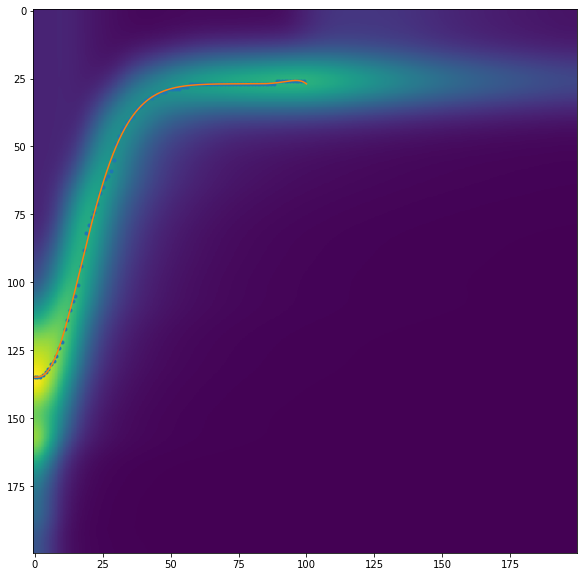

In [620]:
m = random.choice(matrixs[(y.reshape(-1)==20)])
_x, _y, _z = grt_polyfit_x_y_z(m)

p = np.poly1d(_z)
print(_z)
xp = np.linspace(0, 100, 1000)
plt.plot(_x, _y, '.', xp, p(xp), '-')#, xp, p30(xp), '--')

In [621]:
polyfit_z = Parallel(n_jobs=c.NUM_CORES)(delayed(grt_polyfit_z)(m) for m in tqdm(matrixs))

100%|██████████| 6646/6646 [00:03<00:00, 2059.50it/s]


In [622]:
_y =np.hstack((np.array(polyfit_z),  np.sum(np.sum(matrixs, axis=1), axis=1).reshape(-1, 1)))

In [623]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(_y, y)
r = reg.predict(_y)
reg.score(_y, y)

0.985156771638218

In [624]:
for index in [1, 3, 6, 10, 20, 30]:
    d=r[y.reshape(-1)==index].reshape(-1)
    print('{:d}\t{:01.4f} {:01.4f} {:01.4f}'.format(index, np.min(d), np.mean(d), np.max(d)))

1	-0.1730 1.2064 2.8292
3	2.9735 3.3874 3.8014
6	3.5134 5.9288 8.5205
10	9.8790 9.9278 9.9766
20	15.4160 19.8712 25.2435
30	24.7969 27.4932 30.1895


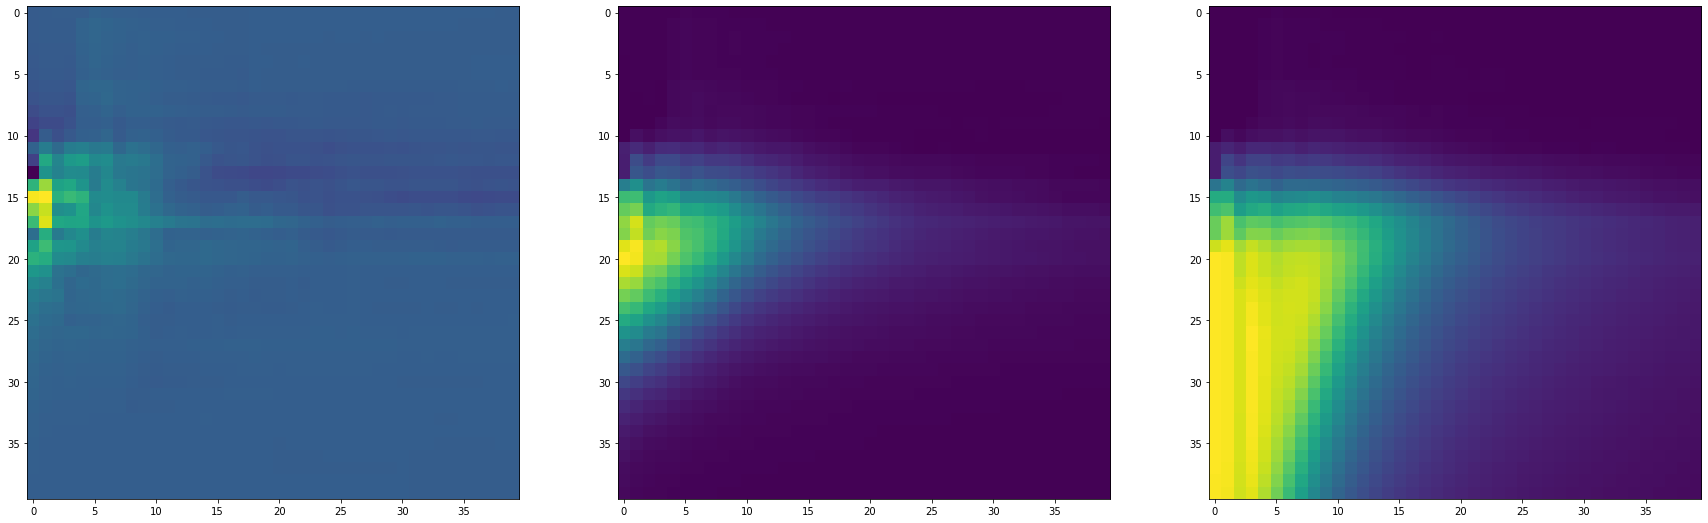

In [193]:
r = np.sum(np.sum((matrixs-averaged_matrices[0]), axis=1), axis=1)
for i in range(1):
    img = random.choice(x[(y.reshape(-1)==1)&(r<0)])
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    for j in range(3):
        m = averaged_matrices[j] - get_matrix(img)
        pos = axs[j].imshow(m)
    #fig.colorbar(pos, extend='max')
    plt.show()

In [136]:
input_layer = k.layers.Input(shape=(40, 40))
layer = k.layers.Reshape((1600,))(input_layer)
layer = k.layers.Dense(3, activation='relu')(layer)
layer = k.layers.Dense(1, activation='relu')(layer)
model = k.models.Model(inputs=[input_layer], outputs=layer)
print(model.summary())

metrics = [
    k.metrics.mean_squared_error,
]
optimizer = k.optimizers.Adam()

model.compile(
    optimizer=optimizer,
    loss=k.losses.mean_squared_error,
    metrics=metrics
)

tb = k.callbacks.TensorBoard(
    log_dir='logs/{}{}_logs'.format(time.strftime('%Y_%m_%d_%H_%M_%S_'), c.FILE_PREFIX),
    write_graph=True,
    update_freq='batch'
)

callbacks = [
    tb,
]

model.fit((np.array(matrixs)-averaged_matrices[1])**3, y, epochs=60, verbose=1, batch_size=c.BATCH_SIZE, validation_split=0.3, callbacks=callbacks)
r=model.predict((np.array(matrixs)-averaged_matrices[2])**3).reshape(-1)

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 40, 40)]          0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 1600)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 4803      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 4         
Total params: 4,807
Trainable params: 4,807
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
291/291 [==============================] - 1s 2ms/step - loss: 17.0072 - mean_squared_error: 17.0072 - val_loss: 10.9587 - val_mean_squared_error: 10.9587
Epoch 2/60
291/291 [==============================] - 0s 997us/step - loss: 10

In [137]:
r

array([0.       , 5.9819236, 5.883203 , ..., 5.9799128, 0.       ,
       0.       ], dtype=float32)

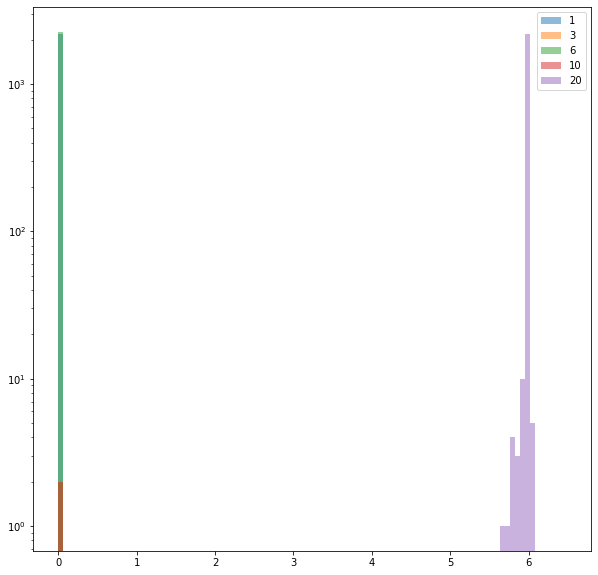

1	0.0000 0.0000 0.0000
3	0.0000 0.0000 0.0000
6	0.0000 0.0000 0.0000
10	0.0000 0.0000 0.0000
20	5.6453 5.9783 6.0456
30	6.0704 6.2718 6.4732


In [138]:
for index in [1, 3, 6, 10, 20]:
    plt.hist(r[y.reshape(-1)==index], log=True, bins=100, alpha=0.5, label=str(index), range=(min(r), max(r)))
plt.legend()
plt.plot()
plt.show()
for index in [1, 3, 6, 10, 20, 30]:
    d=r[y.reshape(-1)==index]
    print('{:d}\t{:01.4f} {:01.4f} {:01.4f}'.format(index, np.min(d), np.mean(d), np.max(d)))

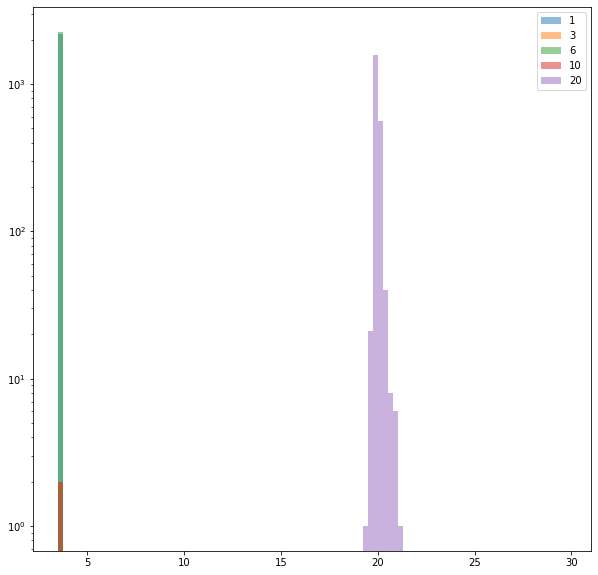

1	3.5131 3.5131 3.5131
3	3.5131 3.5131 3.5131
6	3.5131 3.5131 3.5131
10	3.5131 3.5131 3.5131
20	19.3972 20.0084 21.3132
30	22.3047 26.0032 29.7017


In [135]:
for index in [1, 3, 6, 10, 20]:
    plt.hist(r[y.reshape(-1)==index], log=True, bins=100, alpha=0.5, label=str(index), range=(min(r), max(r)))
plt.legend()
plt.plot()
plt.show()
for index in [1, 3, 6, 10, 20, 30]:
    d=r[y.reshape(-1)==index]
    print('{:d}\t{:01.4f} {:01.4f} {:01.4f}'.format(index, np.min(d), np.mean(d), np.max(d)))

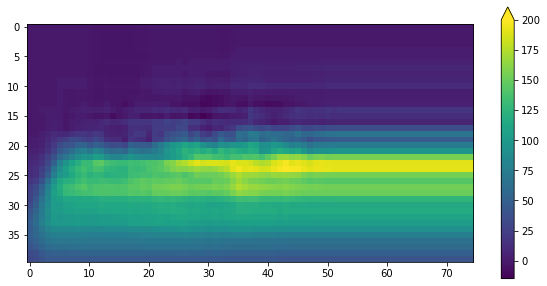

In [63]:
m = get_matrix(x[np.argmax(y==10)])-get_matrix(x[np.argmax(y==6)])
pos = plt.imshow(m)
plt.colorbar(pos, extend='max')
plt.show()

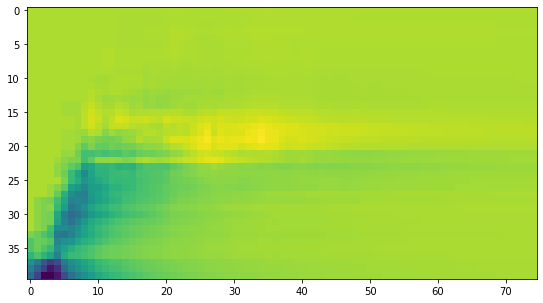

In [59]:
m = get_matrix(x[2])-get_matrix(x[1])
plt.imshow(m)
plt.show()

In [64]:
m = get_matrix(x[2])-get_matrix(x[1])
m.sum()

-29404.0

In [54]:
m = get_matrix(x[np.argmax(y==6)])-get_matrix(x[np.argmax(y==3)])
m.sum()

180838.0

4859.919776023067

In [36]:
np.sum(averaged_matrices[1])/np.sum(get_matrix(img))

2.5834647100443746

1
1
1


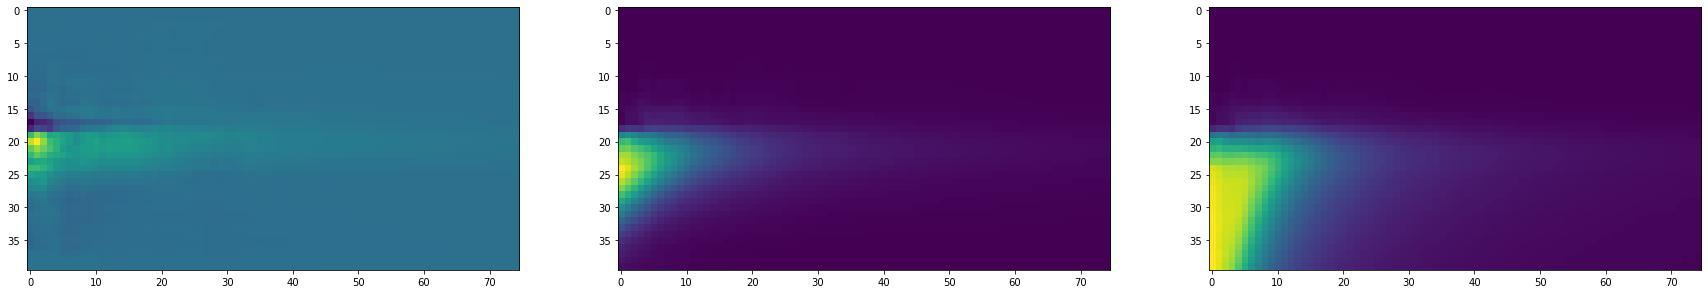

3
3
3


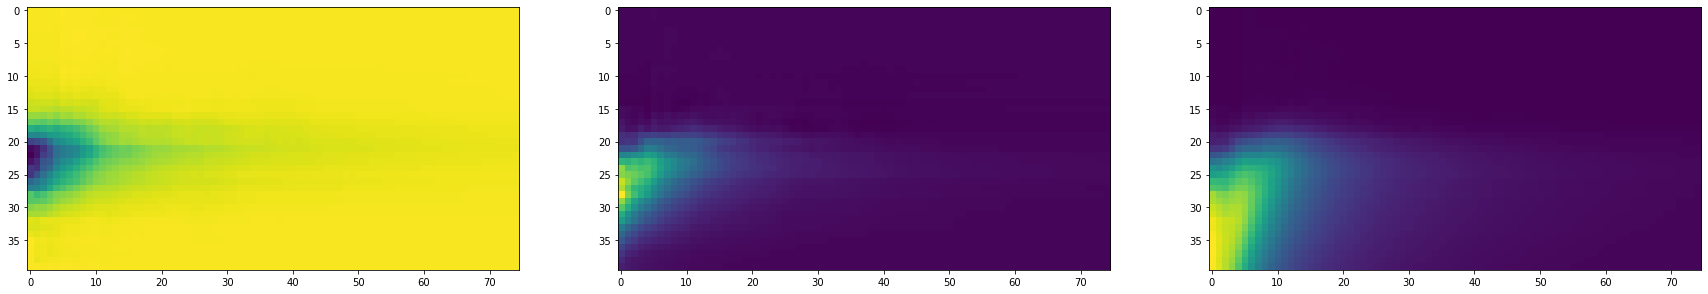

6
6
6


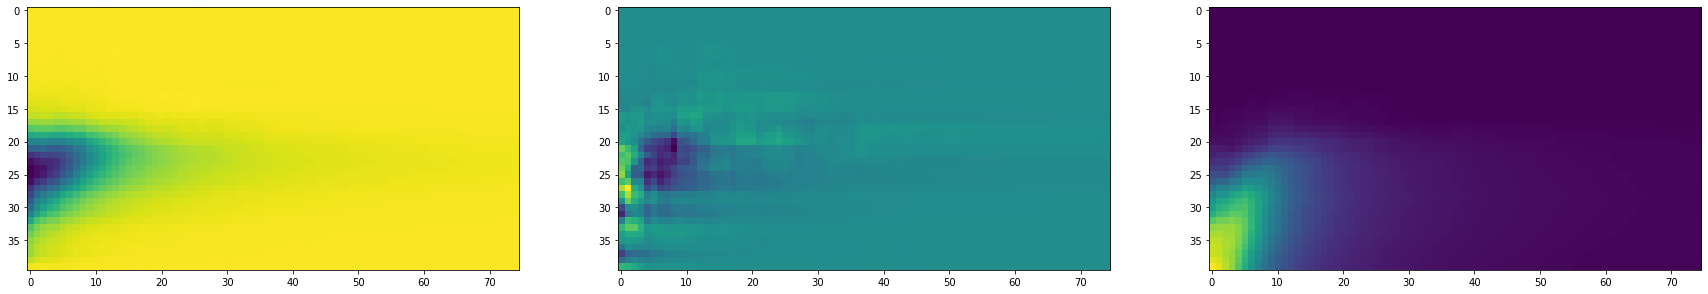

10
10
10


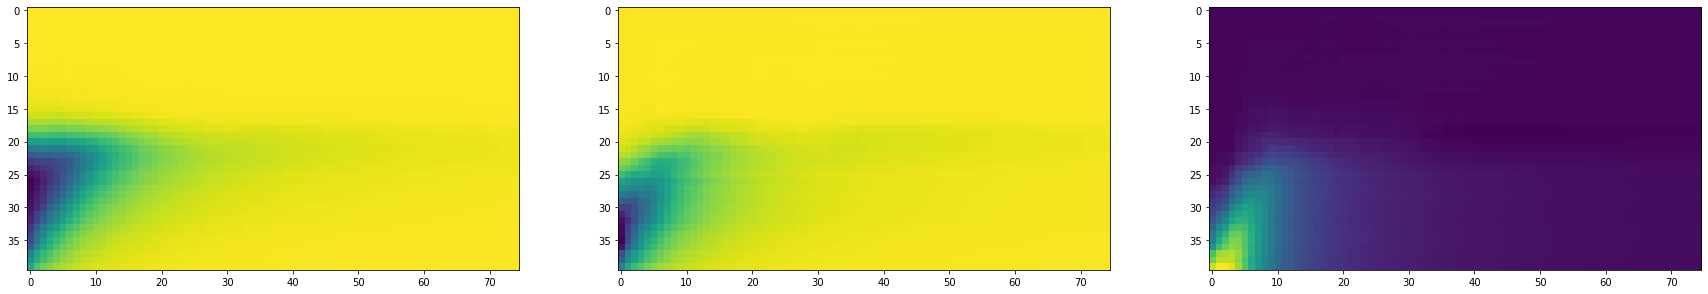

20
20
20


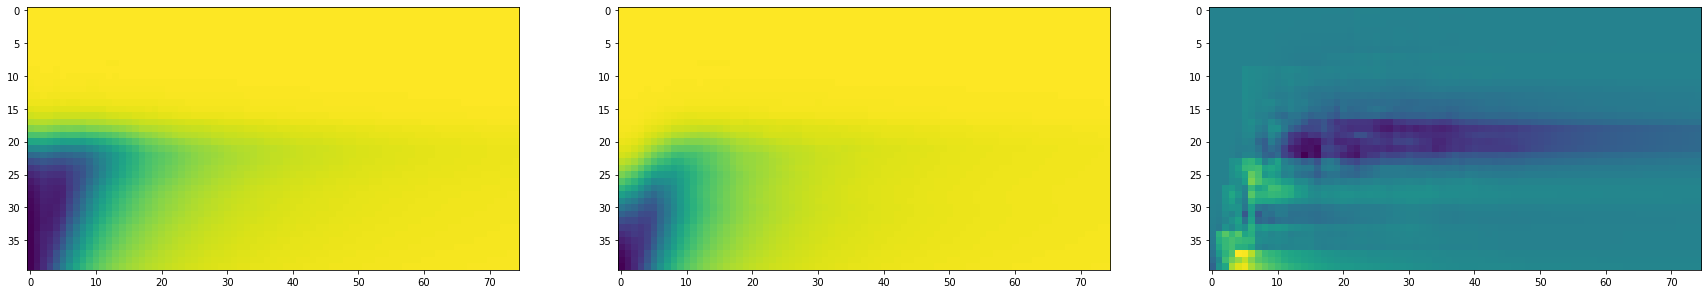

30
30
30


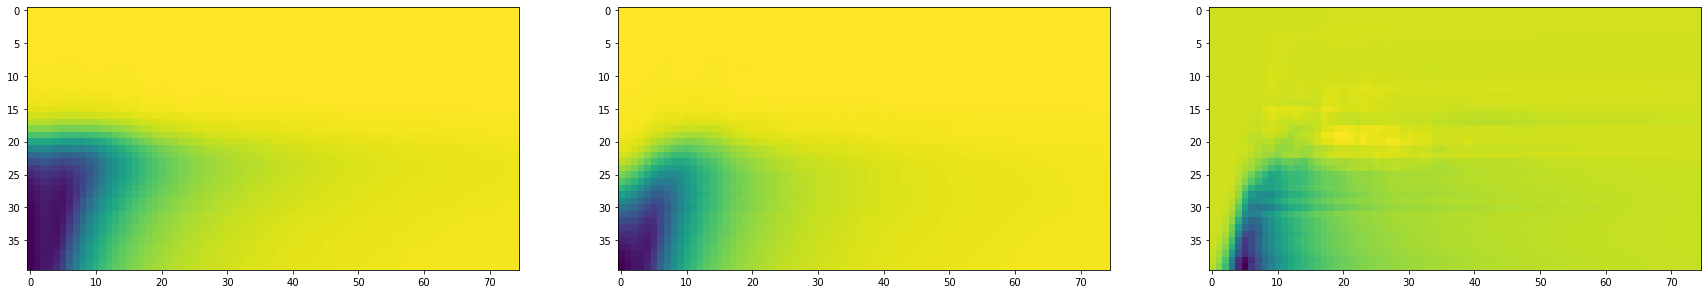

In [60]:
for i, energy in enumerate([1, 3, 6, 10, 20, 30]):
    img = random.choice(x[(y==energy).reshape(-1)])
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    for j in range(3):
        m = averaged_matrices[j] - get_matrix(img)
        pos = axs[j].imshow(m)
        print(energy)
    #fig.colorbar(pos, extend='max')
    plt.show()
    

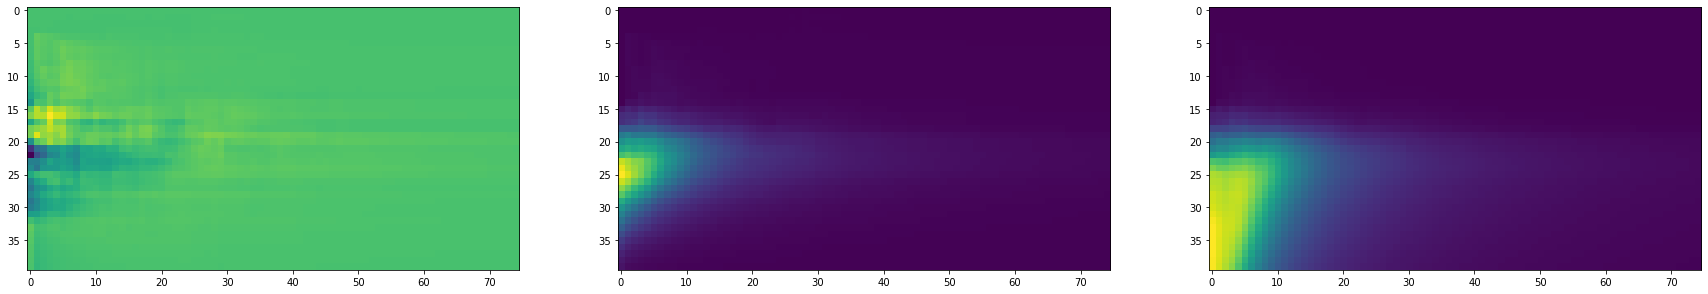

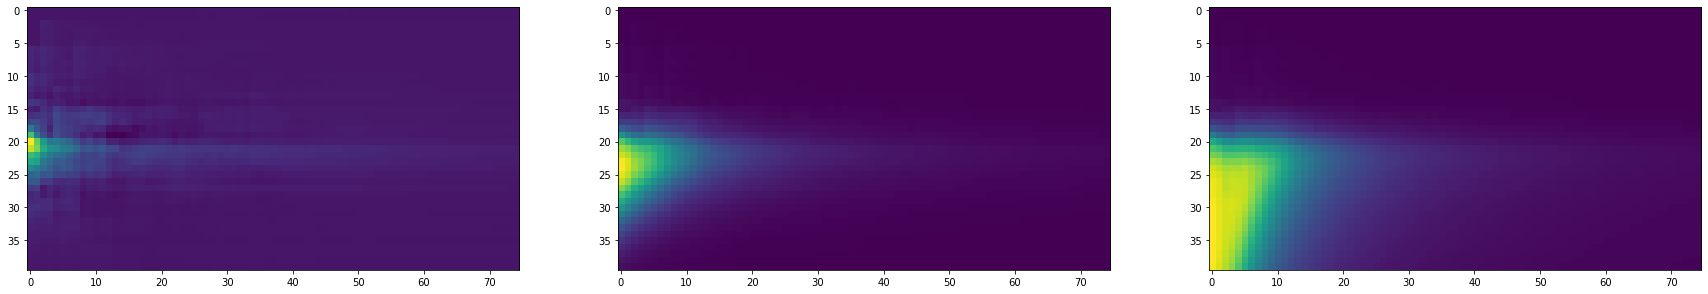

In [62]:
r = np.sum(np.sum(matrixs-averaged_matrices[0], axis=1), axis=1)/80/80
for i in range(2):
    img = random.choice(x[(y.reshape(-1)==1)&(r<10)])
    
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))
    for j in range(3):
        m = averaged_matrices[j] - get_matrix(img)
        pos = axs[j].imshow(m)
    #fig.colorbar(pos, extend='max')
    plt.show()

In [453]:
averaged_matrices_6=[None]*6
averaged_matrices_6[0] = averaged_matrices[0]
averaged_matrices_6[2] = averaged_matrices[1]
averaged_matrices_6[4] = averaged_matrices[2]

averaged_matrices_6[1] = (averaged_matrices[0]+averaged_matrices[1])/2
averaged_matrices_6[3] = (averaged_matrices[1]+averaged_matrices[2])/2
#averaged_matrices_6[5] = (averaged_matrices[2]+averaged_matrices[1])/2

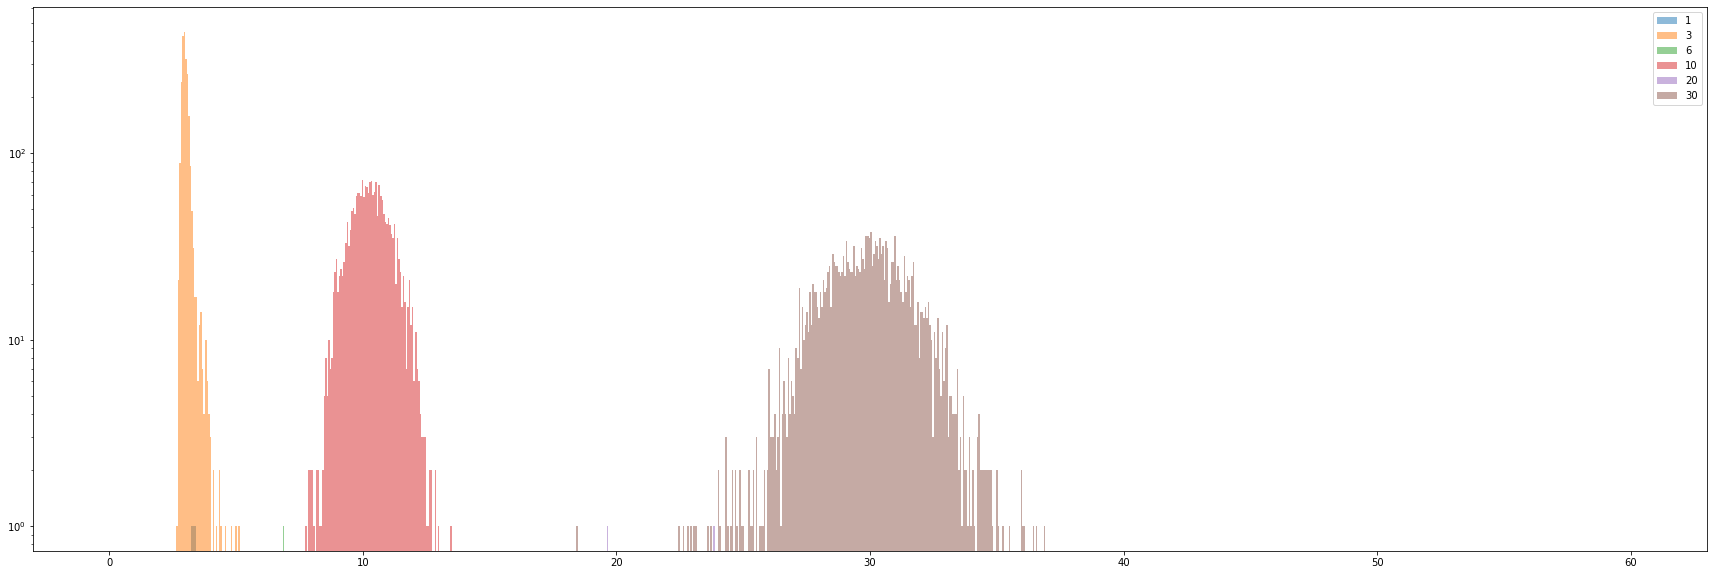

In [4]:
plt.rcParams["figure.figsize"] = (30, 10)
#plt.hist(r.reshape(-1), log=True, bins=300, alpha=0.5)

for v in [1, 3, 6, 10, 20, 30]:
    plt.hist(r[y==v], log=True, bins=1000, range=(0, 60), alpha=0.5, label=str(v))
plt.legend()

plt.show()

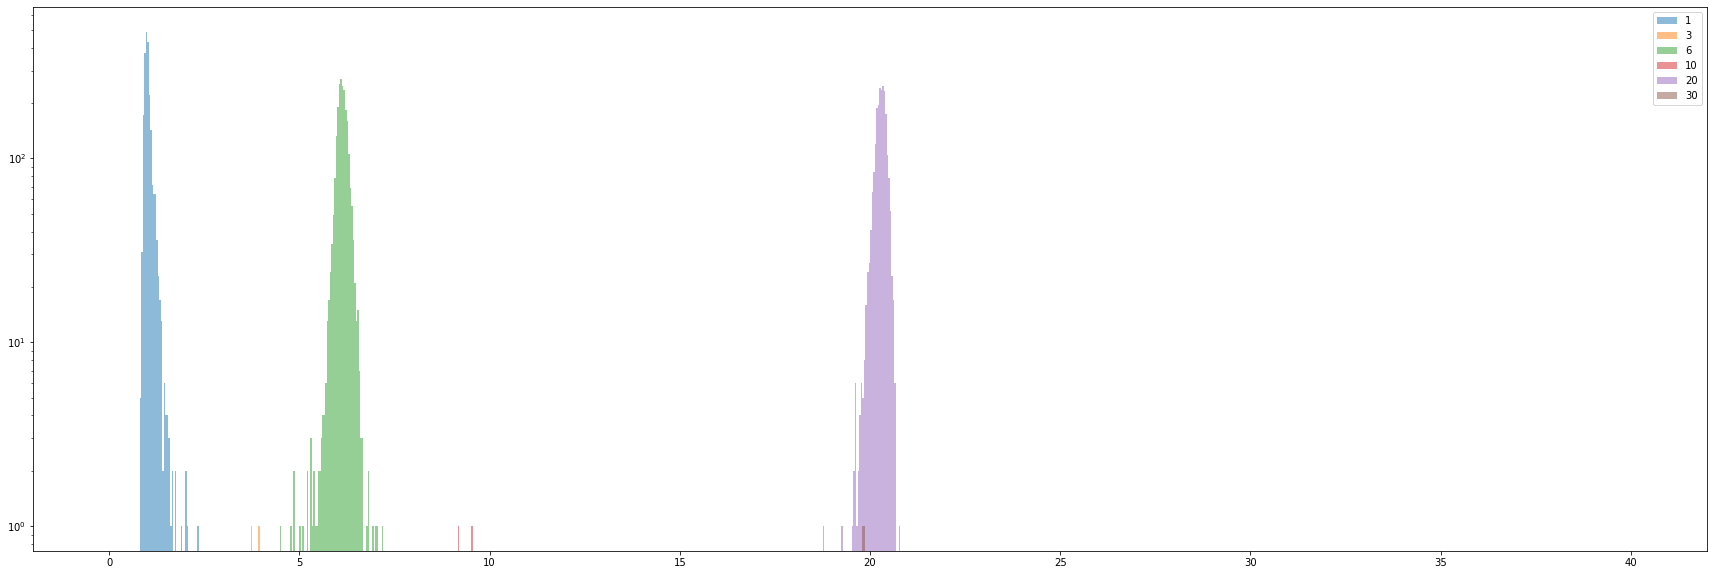

In [9]:
plt.rcParams["figure.figsize"] = (30, 10)
#plt.hist(r.reshape(-1), log=True, bins=300, alpha=0.5)

for v in [1, 3, 6, 10, 20, 30]:
    plt.hist(r[y==v], log=True, bins=1000, range=(0, 40), alpha=0.5, label=str(v))
plt.legend()

plt.show()

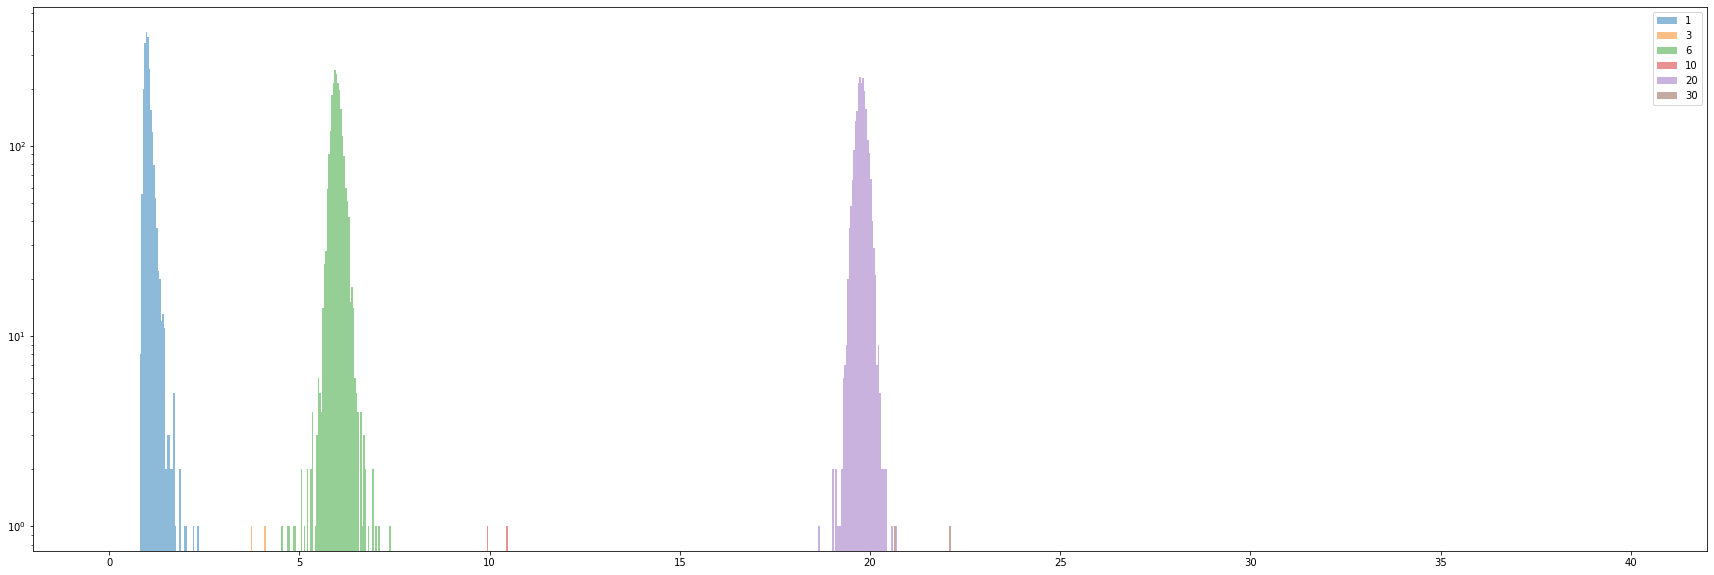

In [7]:
plt.rcParams["figure.figsize"] = (30, 10)
#plt.hist(r.reshape(-1), log=True, bins=300, alpha=0.5)

for v in [1, 3, 6, 10, 20, 30]:
    plt.hist(r[y==v], log=True, bins=1000, range=(0, 40), alpha=0.5, label=str(v))
plt.legend()

plt.show()

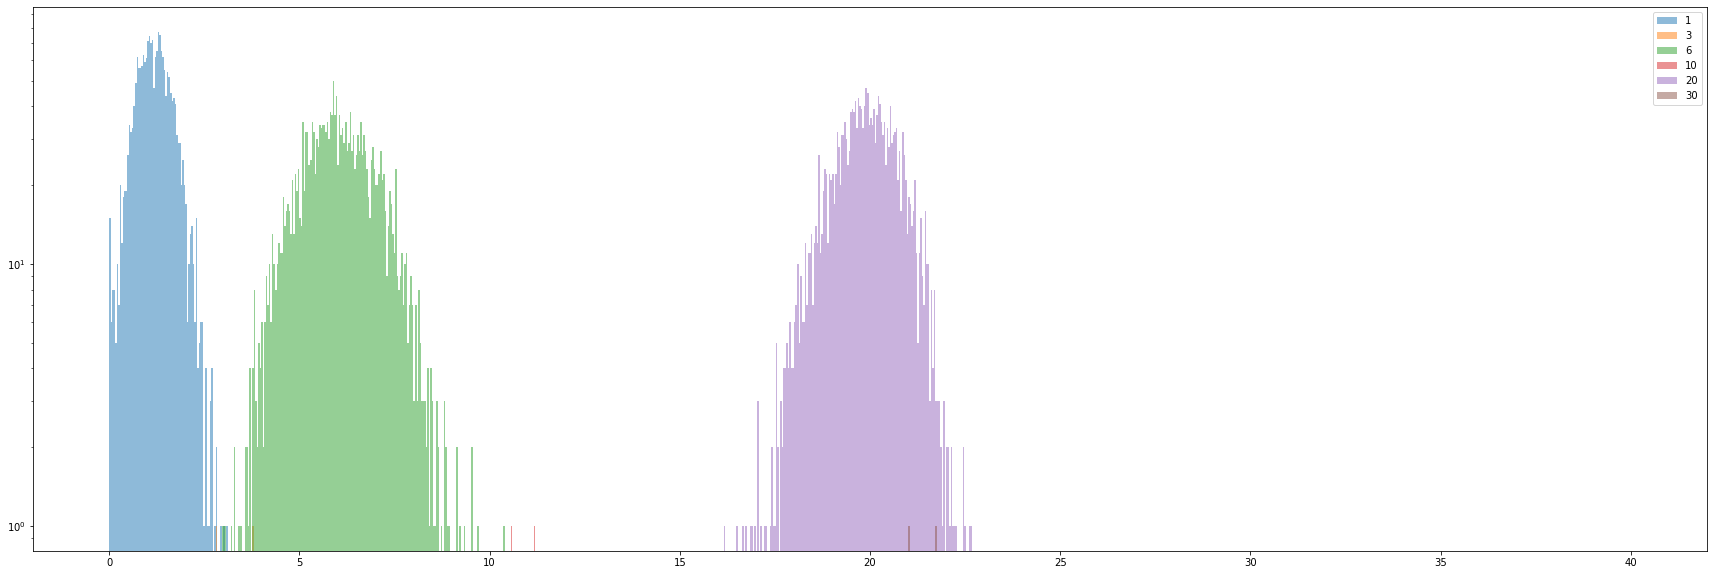

In [21]:
plt.rcParams["figure.figsize"] = (30, 10)
#plt.hist(r.reshape(-1), log=True, bins=300, alpha=0.5)

for k in [1, 3, 6, 10, 20, 30]:
    plt.hist(r[y==k], log=True, bins=1000, range=(0, 40), alpha=0.5, label=str(k))
plt.legend()

plt.show()